In [3]:
# # Kaggle Notebook Workflow for Jane Street Competition
# # Step-by-Step Code Cells to Run Sequentially

# # Step 1: Install Required Packages (Run in a Kaggle Notebook)
# %%capture
# !pip install polars[gpu]==1.9.0 --no-index --find-links=/kaggle/input/janestreet2024-imports-v1/polars
# !pip install lightgbm==4.5.0 --no-index --find-links=/kaggle/input/janestreet2024-imports-v1/packages
# !pip install scikit-learn==1.5.2 --no-index --find-links=/kaggle/input/janestreet2024-imports-v1/packages



In [4]:
# Step 2: Import Required Libraries
import pandas as pd
import numpy as np
import polars as pl
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")




In [5]:
# Step 3: Load Dataset
file_path = '/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet'
df = pd.read_parquet(file_path)
print(df.shape)
df.head(10)

# Step 4: Check Missing Values
missing_values = df.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Values']
missing_values[missing_values['Missing Values'] > 0]

# Step 5: Drop Columns with All Null Values
# Identify columns where all values are null
null_columns = df.columns[df.isnull().all()]

# Drop columns with all null values
df_cleaned = df.drop(columns=null_columns)
print(f"Original shape: {df.shape}")
print(f"Shape after dropping null columns: {df_cleaned.shape}")

# Step 6: Impute Missing Values in Features
# Define the target column
target_column = 'responder_6'

# Separate features and target
X = df_cleaned.drop(columns=[target_column])  # Features
y = df_cleaned[target_column]  # Target variable

# Impute missing values using mean strategy
imputer = SimpleImputer(strategy='mean') 
X_imputed = imputer.fit_transform(X)

# Create a new DataFrame with imputed values
df_imputed = pd.DataFrame(X_imputed, columns=X.columns)
df_imputed[target_column] = y.reset_index(drop=True)  # Add the target column back

# Update df_cleaned
df_cleaned = df_imputed



(1944210, 92)
Original shape: (1944210, 92)
Shape after dropping null columns: (1944210, 83)


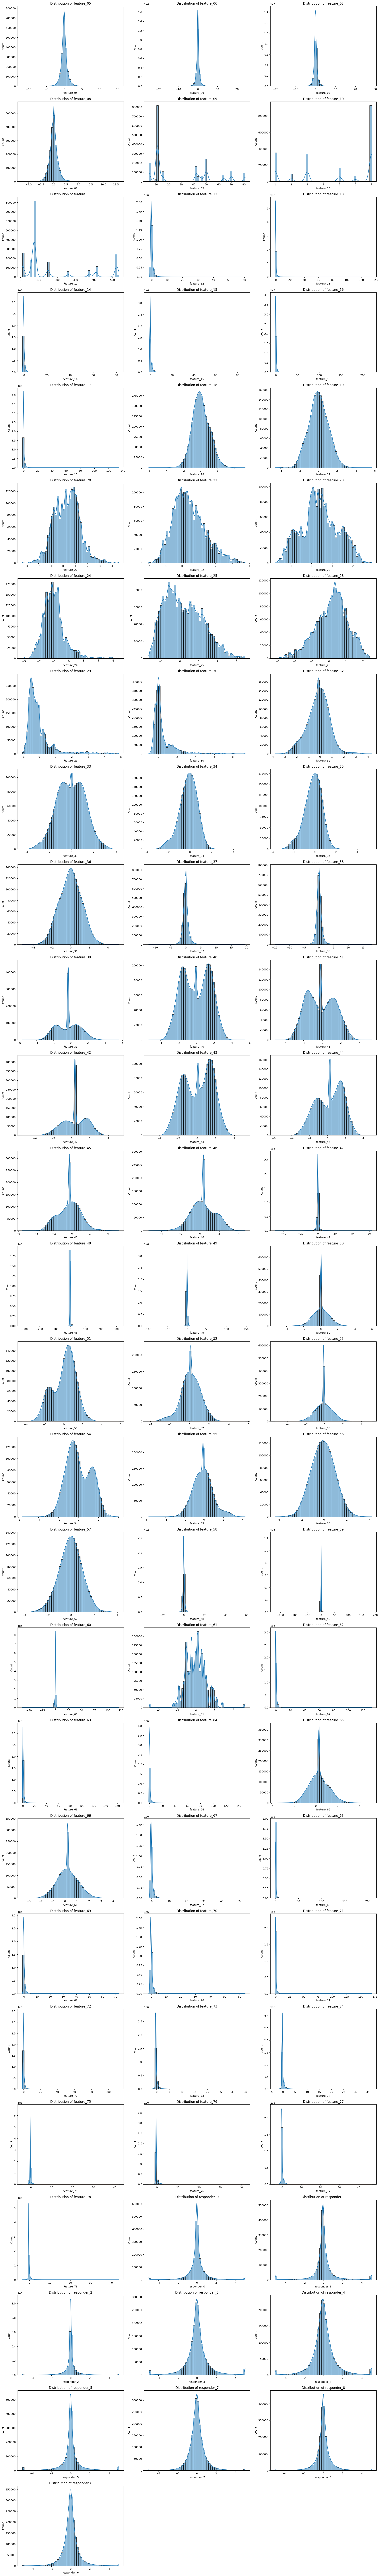

In [6]:
# Step 7: Visualize Feature Distributions
cols_to_plot = [col for col in df_cleaned.columns if 'feature' in col or 'responder' in col]

# Create a grid of subplots
fig, axes = plt.subplots((len(cols_to_plot) + 2) // 3, 3, figsize=(20, 5 * ((len(cols_to_plot) + 2) // 3)))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.histplot(df_cleaned[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



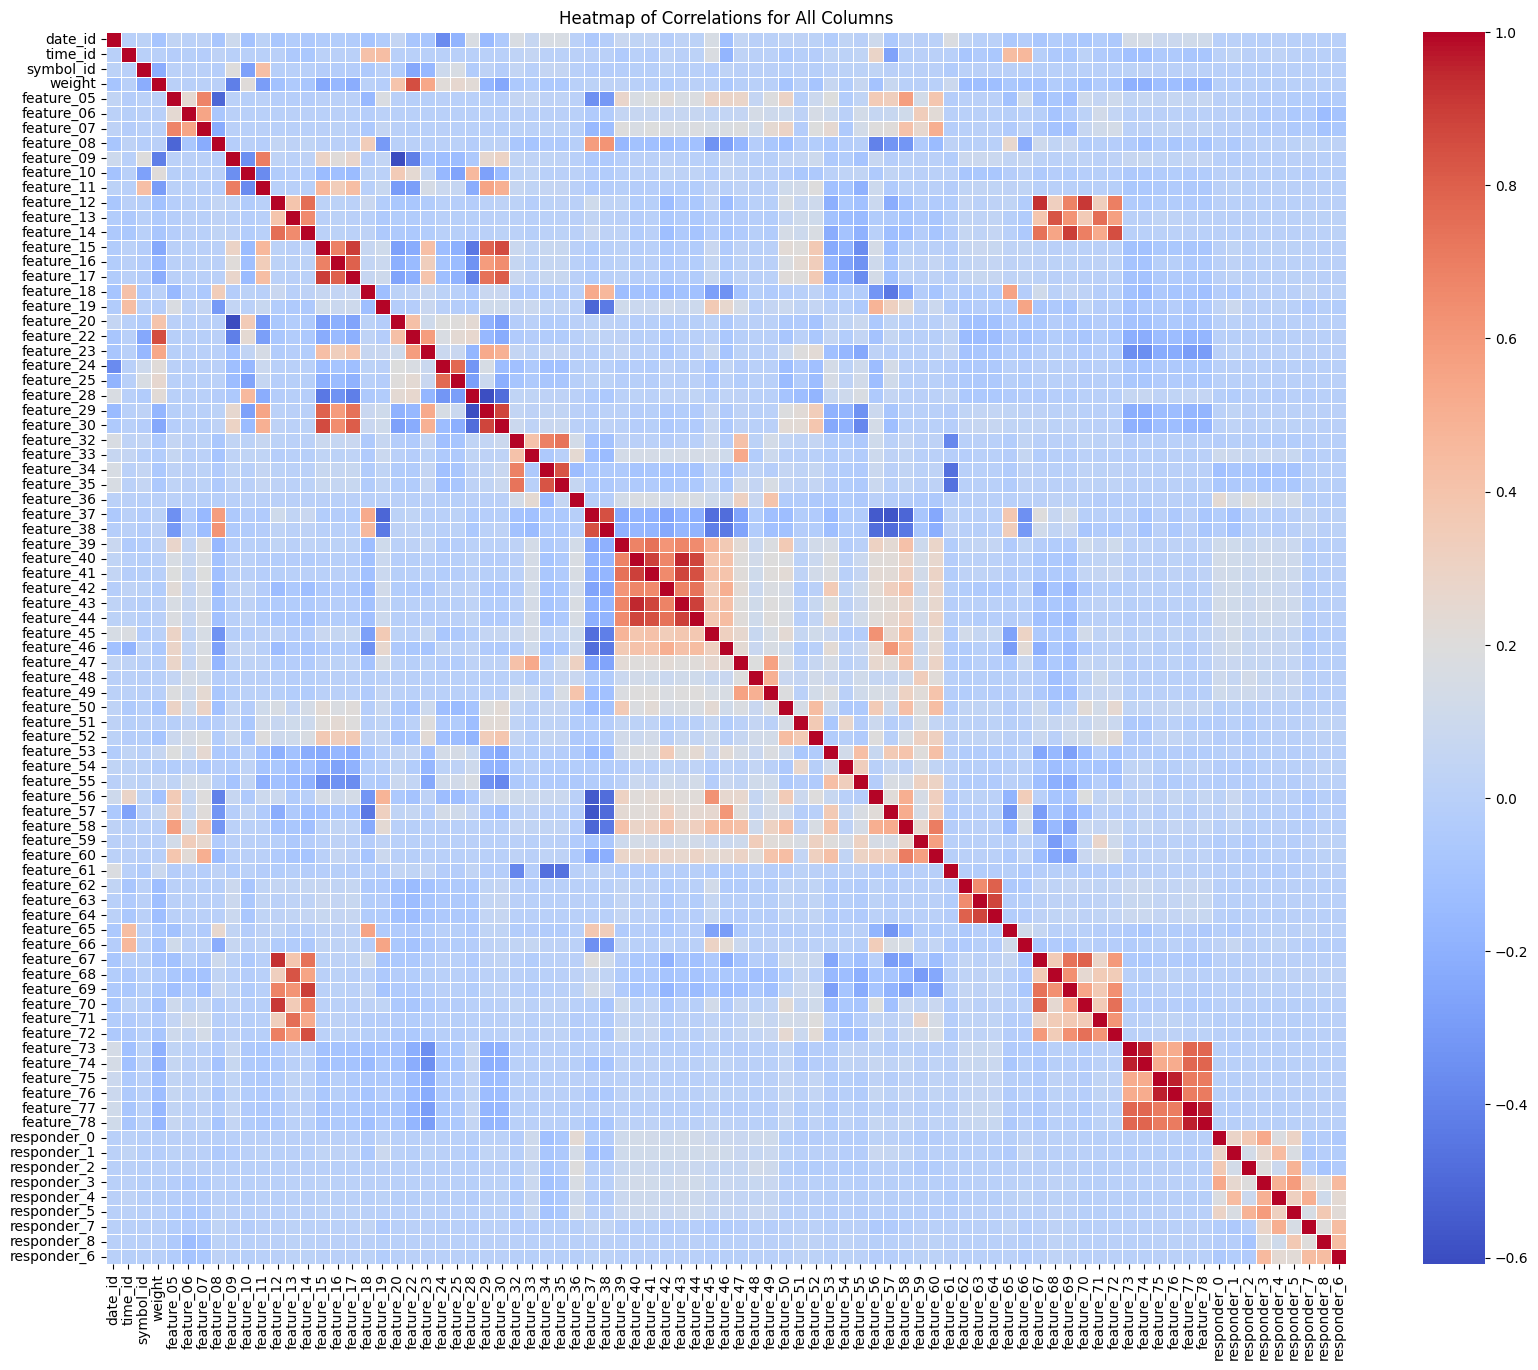

In [7]:
# Step 8: Heatmap of Correlations for All Columns
plt.figure(figsize=(20, 16))
sns.heatmap(df_cleaned.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlations for All Columns')
plt.show()



In [8]:
# Step 9: Train-Test Split and Scaling for XGBoost
features = [col for col in df_cleaned.columns if 'feature_' in col]
X = df_cleaned[features]
y = df_cleaned[target_column]

# Split data (80/20 split without shuffling to maintain order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 10: Train XGBoost Model
model = XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1)
model.fit(X_train_scaled, y_train)

# Step 11: Model Evaluation
y_pred = model.predict(X_test_scaled)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = np.mean(np.abs((y_pred - y_test) / y_test) < 0.10) * 100

print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Custom Accuracy (within 10% of actual): {accuracy:.2f}%")




R-squared: 0.0149
Mean Absolute Error (MAE): 0.6576
Mean Squared Error (MSE): 0.9780
Root Mean Squared Error (RMSE): 0.9890
Mean Absolute Percentage Error (MAPE): 235.65%
Custom Accuracy (within 10% of actual): 1.17%


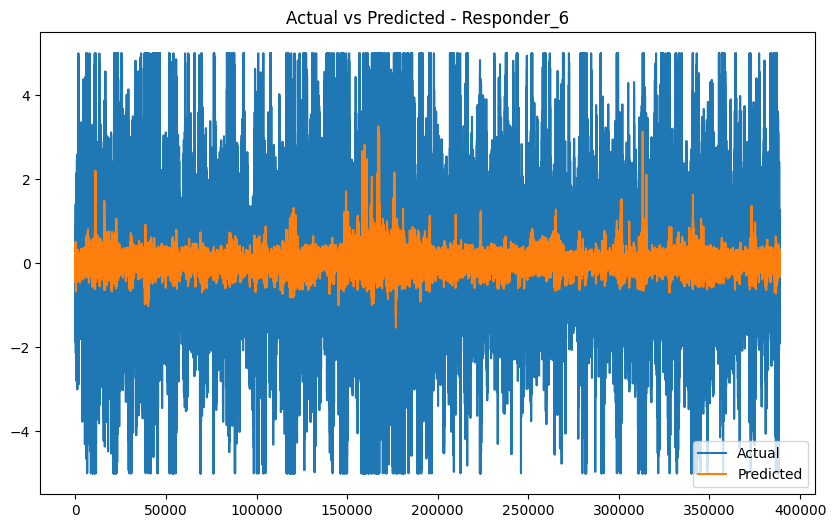

In [9]:
# Step 12: Plot Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted - Responder_6')
plt.legend()
plt.show()


In [10]:
# Step 13: Optional - Prepare Sample Input for Prediction
sample_input = df_cleaned.loc[[89], features]  # Select row 89 as a sample
sample_input_scaled = scaler.transform(sample_input)
sample_prediction = model.predict(sample_input_scaled)

print("Sample Input Data:")
print(sample_input)
print("\nPredicted Value for Sample Input:")
print(sample_prediction)

Sample Input Data:
    feature_05  feature_06  feature_07  feature_08  feature_09  feature_10  \
89    0.653724   -0.084745    0.119095   -0.564572        11.0         7.0   

    feature_11  feature_12  feature_13  feature_14  ...  feature_69  \
89        76.0   -1.114549    -0.35649   -0.583195  ...   -0.164523   

    feature_70  feature_71  feature_72  feature_73  feature_74  feature_75  \
89   -0.978206   -0.312797   -0.624864   -0.498919   -0.348725   -0.277771   

    feature_76  feature_77  feature_78  
89   -0.250952   -0.357971   -0.194685  

[1 rows x 70 columns]

Predicted Value for Sample Input:
[-0.00814252]
